In [9]:
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from pytorch_yolo_v3.util import *
import argparse
import os 
import os.path as osp
from pytorch_yolo_v3.darknet import Darknet
from pytorch_yolo_v3.preprocess import prep_image, inp_to_image
import pandas as pd
import random 
import pickle as pkl
import itertools

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
class test_net(nn.Module):
    def __init__(self, num_layers, input_size):
        super(test_net, self).__init__()
        self.num_layers= num_layers
        self.linear_1 = nn.Linear(input_size, 5)
        self.middle = nn.ModuleList([nn.Linear(5,5) for x in range(num_layers)])
        self.output = nn.Linear(5,2)
    
    def forward(self, x):
        x = x.view(-1)
        fwd = nn.Sequential(self.linear_1, *self.middle, self.output)
        return fwd(x)
        
def get_test_input(input_dim, CUDA):
    img = cv2.imread("pytorch_yolo_v3/dog-cycle-car.png")
    img = cv2.resize(img, (input_dim, input_dim)) 
    img_ =  img[:,:,::-1].transpose((2,0,1))
    img_ = img_[np.newaxis,:,:,:]/255.0
    img_ = torch.from_numpy(img_).float()
    img_ = Variable(img_)
    
    if CUDA:
        img_ = img_.cuda()
    num_classes
    return img_

In [5]:
args = {}
args['description'] = 'YOLO v3 Detection Module'
args['images'] = '/data/detection/images_examples'
args['det'] = '/data/detection/output'
args['bs'] = 1 # batch size
args['confidence'] = 0.5
args['nms_thresh'] = 0.4
args['cfg'] = r'/src/PyTorch/Example_implementation_yolo_v3_ayooshkathuria/pytorch_yolo_v3/cfg/yolov3.cfg'
args['weights'] = 'yolov3.weights'
args['reso'] = 832 # network input resolution # default 416
args['scales'] = '1,2,3,4,5' # default 1,2,3

In [6]:
scales = args['scales']
images = args['images']
batch_size = int(args['bs'])
confidence = float(args['confidence'])
nms_thesh = float(args['nms_thresh'])
start = 0

CUDA = torch.cuda.is_available()

num_classes = 80
classes = load_classes(r'/src/PyTorch/Example_implementation_yolo_v3_ayooshkathuria/pytorch_yolo_v3/data/coco.names') 

#Set up the neural network
print("Loading network.....")
model = Darknet(args['cfg'])
model.load_weights(args['weights'])
print("Network successfully loaded")
    
model.net_info["height"] = args['reso']
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()
    
    
#Set the model in evaluation mode
model.eval()
  

Loading network.....
Network successfully loaded


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): Batch

In [7]:
def run_img(model, args, image_path):
    read_dir = time.time()
    #Detection phase
    try:
        imlist = [image_path]
    except NotADirectoryError:
        imlist = []
        imlist.append(osp.join(osp.realpath('.'), images))
    except FileNotFoundError:
        print ("No file or directory with the name {}".format(images))
        exit()

    if not os.path.exists(args['det']):
        os.makedirs(args['det'])

    load_batch = time.time()

    batches = list(map(prep_image, imlist, [inp_dim for x in range(len(imlist))]))
    im_batches = [x[0] for x in batches]
    orig_ims = [x[1] for x in batches]
    im_dim_list = [x[2] for x in batches]
    im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)



    if CUDA:
        im_dim_list = im_dim_list.cuda()

    leftover = 0

    if (len(im_dim_list) % batch_size):
        leftover = 1


    if batch_size != 1:
        num_batches = len(imlist) // batch_size + leftover            
        im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                            len(im_batches))]))  for i in range(num_batches)]        


    i = 0


    write = False
    model(get_test_input(inp_dim, CUDA), CUDA)

    start_det_loop = time.time()

    objs = {}

    for batch in im_batches:
        #load the image 
        start = time.time()
        if CUDA:
            batch = batch.cuda()


        #Apply offsets to the result predictions
        #Tranform the predictions as described in the YOLO paper
        #flatten the prediction vector 
        # B x (bbox cord x no. of anchors) x grid_w x grid_h --> B x bbox x (all the boxes) 
        # Put every proposed box as a row.
        with torch.no_grad():
            prediction = model(Variable(batch), CUDA)

    #        prediction = prediction[:,scale_indices]

        #get the boxes with object confidence > threshold
        #Convert the cordinates to absolute coordinates
        #perform NMS on these boxes, and save the results 
        #I could have done NMS and saving seperately to have a better abstraction
        #But both these operations require looping, hence 
        #clubbing these ops in one loop instead of two. 
        #loops are slower than vectorised operations. 

        prediction = write_results(prediction, confidence, num_classes, nms = True, nms_conf = nms_thesh)


        if type(prediction) == int:
            i += 1
            continue

        end = time.time()


    #        print(end - start)



        prediction[:,0] += i*batch_size




        if not write:
            output = prediction
            write = 1
        else:
            output = torch.cat((output,prediction))




        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
            print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
            print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
            print("----------------------------------------------------------")
        i += 1


        if CUDA:
            torch.cuda.synchronize()

    try:
        output
    except NameError:
        print("No detections were made")
        exit()

    im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

    scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)


    output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
    output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2



    output[:,1:5] /= scaling_factor

    for i in range(output.shape[0]):
        output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
        output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])


    output_recast = time.time()


    class_load = time.time()

    colors = pkl.load(open("pytorch_yolo_v3/pallete", "rb"))


    draw = time.time()


    def write(x, batches, results):
        c1 = tuple(x[1:3].int())
        c2 = tuple(x[3:5].int())
        img = results[int(x[0])]
        cls = int(x[-1])
        label = "{0}".format(classes[cls])
        color = random.choice(colors)
        cv2.rectangle(img, c1, c2,color, 1)
        t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
        c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
        cv2.rectangle(img, c1, c2,color, -1)
        cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
        return img


    list(map(lambda x: write(x, im_batches, orig_ims), output))

    det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format(args['det'],x.split("/")[-1]))

    list(map(cv2.imwrite, det_names, orig_ims))

    end = time.time()

    print()
    print("SUMMARY")
    print("----------------------------------------------------------")
    print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
    print()
    print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
    print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
    print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop))
    print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast))
    print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
    print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
    print("----------------------------------------------------------")


    torch.cuda.empty_cache()


lea_wolf.jpg         predicted in  0.091 seconds
Objects Detected:    person dog
----------------------------------------------------------

SUMMARY
----------------------------------------------------------
Task                     : Time Taken (in seconds)

Reading addresses        : 0.000
Loading batch            : 0.192
Detection (1 images)     : 0.092
Output Processing        : 0.000
Drawing Boxes            : 0.026
Average time_per_img     : 0.311
----------------------------------------------------------


(-0.5, 2047.5, 1762.5, -0.5)

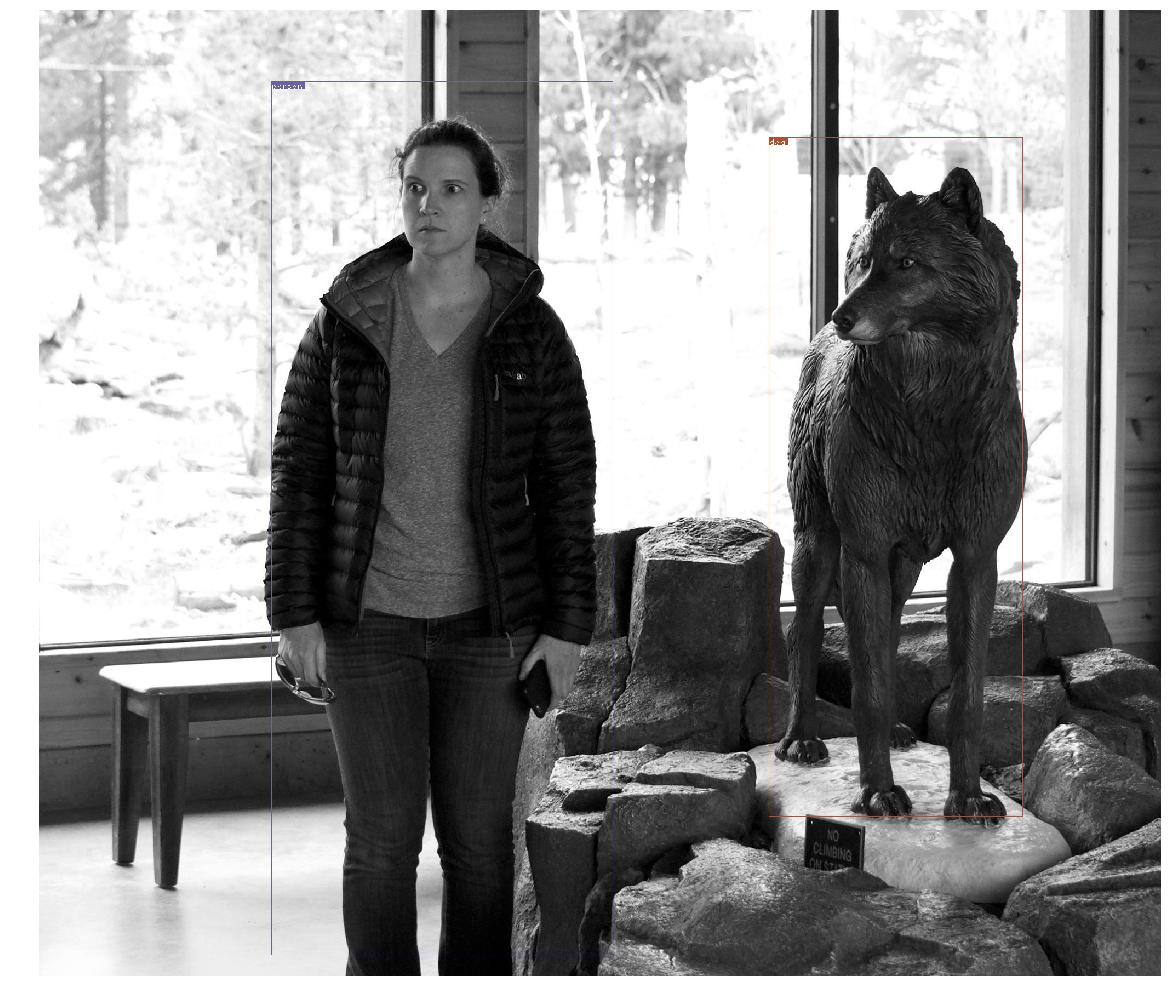

In [17]:

filenamepart = 'lea_wolf.jpg'
run_img(model, args, r'/data/detection/images_examples/%s' % filenamepart)
fig, ax = plt.subplots(figsize=(18, 14))
ax.imshow(plt.imread(r'/data/detection/output/det_%s' % filenamepart))
plt.tight_layout()
plt.axis('off')
# plt.imshow(plt.imread(r'/data/detection/output/det_beach.jpg'), size=(15, 15))
        